### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 25 ноября 2019, 15:00   
**Штраф за опоздание:** -2 балла после 15:00 25 ноября, -4 балла после 15:00 2 декабря, -6 баллов после 15:00 9 декабря  -8 баллов после 15:00 16 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (3 балла)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на [wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) и [Speed Dating Data](https://cloud.mail.ru/public/8nHV/p6J7wY1y1)

###### Задание 2 (3 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine и Speed Dating Data. 
Для этого используем numpy.

###### Задание 3 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 4 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 4 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw3.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import flake8
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split,\
    GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns

%matplotlib inline
%load_ext pycodestyle_magic

In [3]:
%flake8_on

In [4]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self,
                 min_samples_split=2,
                 max_depth=None,
                 sufficient_share=1.0,
                 criterion='gini',
                 max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.num_features = -1
        self.feature_importances_ = None

        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features is None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __get_class_proportions(self, y):
        return np.divide(np.bincount(y, minlength=self.num_class), y.size)

    def __gini_H(self, props):
        return 1 - np.sum(np.power(props, 2))

    def __entropy_H(self, props):
        logP = np.log(props)
        logP[logP == -np.inf] = 0.
        return np.sum(-props * logP)

    def __misclass_H(self, props):
        return 1 - np.max(props)

    def __get_G_arguments(self, left_labels, right_labels):
        l_c = self.__get_class_proportions(left_labels)
        r_c = self.__get_class_proportions(right_labels)

        l_s = left_labels.size
        r_s = right_labels.size

        return l_c, l_s, r_c, r_s

    def __gini(self, l_c, l_s, r_c, r_s):
        return (l_s / (l_s + r_s)) * self.__gini_H(l_c) +\
               (r_s / (l_s + r_s)) * self.__gini_H(r_c)

    def __entropy(self, l_c, l_s, r_c, r_s):
        return (l_s / (l_s + r_s)) * self.__entropy_H(l_c) +\
               (r_s / (l_s + r_s)) * self.__entropy_H(r_c)

    def __misclass(self, l_c, l_s, r_c, r_s):
        return (l_s / (l_s + r_s)) * self.__misclass_H(l_c) +\
               (r_s / (l_s + r_s)) * self.__misclass_H(r_c)

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = list(range(n_feature))
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.sqrt(len(feature_ids)))]

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = list(range(n_feature))
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.log2(len(feature_ids)))]

    def __get_feature_ids_N(self, n_feature):
        return range(n_feature)

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __div_samples_y(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):

        f_val = np.full((x.shape[1], 2), np.inf)

        for f_id in self.get_feature_ids(x.shape[1]):
            val = np.unique(x[:, f_id])
            best_gain = np.inf

            for v in val:
                y_left, y_right = self.__div_samples_y(x, y, f_id, v)
                if y_left.size == 0 or y_right.size == 0:
                    continue

                gain = self.G_function(
                    *self.__get_G_arguments(y_left, y_right))
                if gain < best_gain:
                    best_gain = gain
                    f_val[f_id] = [v, gain]

        best_feature, split_value, best_gain =\
            f_val[:, 1].argmin(), *f_val[f_val[:, 1].argmin()]

        return best_feature, split_value, best_gain

    def __create_leaf(self, y):
        probs = self.__get_class_proportions(y)
        pred = probs.argmax()
        return self.__class__.LEAF_TYPE, pred, probs

    def __fit_node(self, x, y, node_id, depth):

        # проверяем число объектов
        if x.shape[0] < self.min_samples_split:
            self.tree[node_id] = self.__create_leaf(y)
            return

        # проверяем глубину
        elif self.max_depth is not None:
            if depth >= self.max_depth:
                self.tree[node_id] = self.__create_leaf(y)
                return

        if np.unique(y).size == 1:
            self.tree[node_id] = self.__create_leaf(y)
            return

        node_impurity = self.__gini_H(self.__get_class_proportions(y))

        best_feature, split_value, best_gain =\
            self.__find_threshold(x, y)

        x_left, x_right, y_left, y_right =\
            self.__div_samples(x, y, best_feature, split_value)

        self.tree[node_id] = (self.__class__.NON_LEAF_TYPE,
                              best_feature,
                              split_value,
                              node_impurity-best_gain)

        self.__fit_node(x_left,  y_left,
                        2 * node_id + 1, depth+1)
        self.__fit_node(x_right, y_right,
                        2 * node_id + 2, depth+1)

    def fit(self, x, y):
        self.num_features = x.shape[1]
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)

        self.compute_feature_importances()

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold, *__ = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold, *__ = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    def compute_feature_importances(self):
        self.feature_importances_ = np.zeros(self.num_features)
        for _, node in self.tree.items():
            if node[0] == self.__class__.NON_LEAF_TYPE:
                self.feature_importances_[node[1]] += node[3]
        self.feature_importances_ /= self.feature_importances_.sum()

In [5]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2, random_state=2019)

In [6]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data,
                                                    wine.target,
                                                    test_size=0.1,
                                                    stratify=wine.target,
                                                    random_state=2019)

## Проверка скорости работы на wine

In [7]:
%time clf.fit(X_train, y_train)

CPU times: user 2.3 ms, sys: 0 ns, total: 2.3 ms
Wall time: 1.54 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2019, splitter='best')

In [8]:
%time my_clf.fit(X_train, y_train)

CPU times: user 210 ms, sys: 8.18 ms, total: 218 ms
Wall time: 213 ms


## Проверка качества работы на wine

In [9]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.8372183372183373

In [10]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.8372183372183373

## Подготовка данных Speed Dating Data 

In [11]:
speed_dating_filname = "data/speed-dating-experiment/Speed Dating Data.csv"
speed_dating = pd.read_csv(speed_dating_filname, encoding="ISO-8859-1")

In [12]:
sd_target = speed_dating.pop('match').values

Наш алгоритм не умеет работать с пропущенными значениями, поэтому мы применим простой трюк: удалим все фичи с пропусками

In [13]:
speed_dating_pro = speed_dating.dropna(axis=1)

Уберем из обучающей выборки все признаки, являющиеся идентификаторами. Т.к. идентификаторами присваиваются объектам произвольным образом, эти признаки не несут никакой полезной информации и их использование приведет к переобучению модели

In [14]:
id_columns = ['idg', 'iid', 'partner']

In [15]:
speed_dating_pro = speed_dating_pro.drop(columns=id_columns)

In [16]:
X_sd = speed_dating_pro.values

In [17]:
X_sd.shape, sd_target.shape

((8378, 9), (8378,))

Делим на трейн и тест

In [18]:
X_sd_train, X_sd_test, y_sd_train, y_sd_test =\
    train_test_split(X_sd, sd_target, test_size=0.1,
                     stratify=sd_target, random_state=1)

## Проверка скорости работы на Speed Dating Data 

In [19]:
my_clf_sd = MyDecisionTreeClassifier(min_samples_split=2)
clf_sd = DecisionTreeClassifier(min_samples_split=2, random_state=1)

In [20]:
%time clf_sd.fit(X_sd_train, y_sd_train)

CPU times: user 3.21 ms, sys: 274 µs, total: 3.48 ms
Wall time: 2.92 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [21]:
%time my_clf_sd.fit(X_sd_train, y_sd_train)

CPU times: user 26.7 ms, sys: 0 ns, total: 26.7 ms
Wall time: 26.4 ms


## Проверка качества работы на Speed Dating Data

In [22]:
f1_score(y_pred=clf_sd.predict(X_sd_test), y_true=y_sd_test, average='macro')

1.0

In [23]:
f1_score(y_pred=my_clf_sd.predict(X_sd_test), y_true=y_sd_test, average='macro')

1.0

## Задание 4: feature importances

### Wine dataset

Text(0, 0.5, 'feature_id')

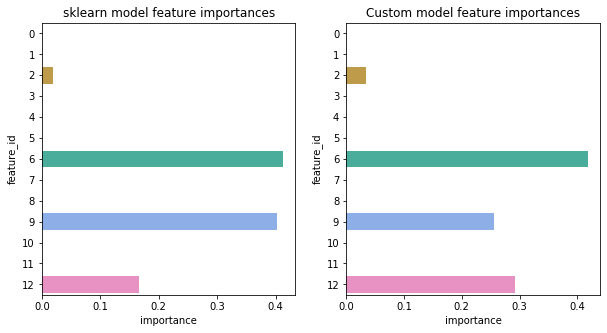

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=clf.feature_importances_,
            y=list(range(my_clf.num_features)), orient='h', ax=axes[0])
axes[0].set_title("sklearn model feature importances")
axes[0].set_ylabel('feature_id')
axes[0].set_xlabel('importance')

sns.barplot(x=my_clf.feature_importances_,
            y=list(range(my_clf.num_features)), orient='h', ax=axes[1])
axes[1].set_title("Custom model feature importances")
axes[1].set_xlabel('importance')
axes[1].set_ylabel('feature_id')

### Speed Dating dataset

Text(0, 0.5, 'feature_id')

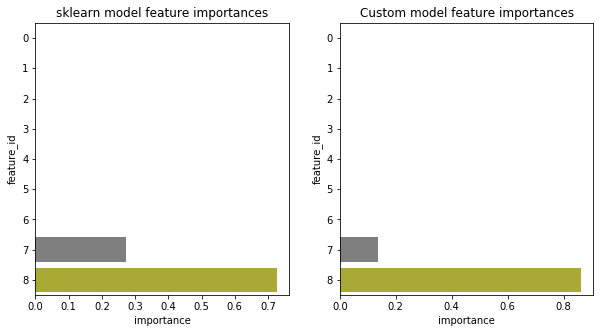

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=clf_sd.feature_importances_,
            y=list(range(my_clf_sd.num_features)), orient='h', ax=axes[0])
axes[0].set_title("sklearn model feature importances")
axes[0].set_ylabel('feature_id')
axes[0].set_xlabel('importance')

sns.barplot(x=my_clf_sd.feature_importances_,
            y=list(range(my_clf_sd.num_features)), orient='h', ax=axes[1])
axes[1].set_title("Custom model feature importances")
axes[1].set_xlabel('importance')
axes[1].set_ylabel('feature_id')

## Задание 5

In [26]:
params = {
    'min_samples_split': [2, 3, 4, 5, 7, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [2, 5, 10]
}

strat_cv = StratifiedKFold(n_splits=5,
                           shuffle=False,
                           random_state=1)

In [27]:
grid_search_CV = GridSearchCV(RandomForestClassifier(),
                              param_grid=params,
                              cv=strat_cv,
                              scoring="f1_macro",
                              n_jobs=12,
                              )

In [28]:
grid_search_CV.fit(X_sd, sd_target)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
           

In [29]:
grid_search_CV.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)